In [100]:
#reference
#https://scikit-learn.org/stable/
#https://xgboost.readthedocs.io/en/latest/python/python_intro.html
#https://pypi.org/project/PrettyTable/

In this notebook we will find the best model which can perform good on our dataset in which we have not include any Histogram's bin columns during EDA , it mean we have directly removed all Histogram's bin columns so in this dataset in which we have selected best features only from the measure column

In [101]:
import tqdm
import numpy as np
import pandas as pd
import imblearn
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

sns.set_style(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

In [102]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [103]:
#We have use this fuction to print the confusion, Precision and Recall matrix 
#reference: https://colab.research.google.com/drive/1YQoysuPgCDJ_HyOuclAYMVd04JNAjzP6

def plot_confusion_matrix(test_y, predict_y):
    #Confusion matrix
    C = confusion_matrix(test_y, predict_y)
    
    #precision matrix 
    A =(((C.T)/(C.sum(axis=1))).T)
    
    #recall matrix 
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")

    #Heatmap of Confusion matrix
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    #Heatmap of Presicion matrix
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    #Heatmap of Recall matrix 
    plt.subplot(1, 3, 3)
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [104]:
#Data Loading
data = pd.read_csv(r'/content/drive/My Drive/Case-Study 2 /Datasets/final_data.csv')
data.head()

,target,sensor1_measure,sensor15_measure,sensor16_measure,sensor17_measure,sensor27_measure,sensor33_measure,sensor35_measure,sensor45_measure,sensor46_measure,sensor47_measure,sensor48_measure,sensor53_measure,sensor55_measure,sensor60_measure,sensor66_measure
0,0.0,40626.0,2495580.0,864780.0,509424.0,3980738.0,75288.0,480466.0,40625.07,3980738.0,3980738.0,3975938.0,3782688.0,0.0,0.0,0.0
1,0.0,82.0,6684.0,24010.0,2060.0,35448.0,300.0,4460.0,82.42,35448.0,35448.0,30426.0,14088.0,0.0,0.0,0.0
2,0.0,61834.0,3519322.0,1724710.0,399610.0,5787428.0,64124.0,479432.0,61834.46,5787428.0,5787428.0,5780574.0,4504504.0,147646.0,0.0,130.0
3,0.0,37028.0,1917384.0,662454.0,287446.0,2940310.0,38520.0,246210.0,37027.64,2940310.0,2940310.0,2929250.0,2603786.0,71304.0,0.0,92.0
4,0.0,60682.0,3239938.0,665430.0,380472.0,4355786.0,42342.0,347630.0,60681.80,4355786.0,4355786.0,4357888.0,4086220.0,134536.0,0.0,38.0


In [105]:
#Data Preprocessing and Train-Test split

X = data.iloc[:, 1:].values
y = np.array(list(map(int, data.iloc[:, 0].values))).reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=0.15)
X_train, X_cv, y_train, y_cv = train_test_split(X_train,y_train, test_size=0.15)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_cv = scaler.transform(X_cv)
X_test = scaler.transform(X_test)

X_train.shape, y_train.shape, X_cv.shape, y_cv.shape,X_test.shape, y_test.shape

((25817, 15), (25817, 1), (4557, 15), (4557, 1), (5361, 15), (5361, 1))

##Search for Best Model:-

##Metric: F1-Score(Micro):
so to select best model we will use F1 score (micro) because 'micros' Calculate metrics globally by counting the total true positives, false negatives and false positives, 
  and for our problem false positives and false positives matters alot so instead of taking simple f1-score, we choose this as KPI matric for our problm

here we will train 6 different models and will find best hyperparameters by train and testing the model on cv set using Linear Search , And then we will train these model using that tuned hyperparameter and after these trained model we will calculate the micro F1-score of test data and then we will compare the best result and select the best model which will give the highest micro F1-score on Test data 

##Models that we are going to train for this Experiments:
##1) Random (For findng the worst case)
##2) Logistic Regression
##3) KNN
##4) SVM(Linear)
##5) SVM(RBF)
##6) Decision Tree Classifier
##7) Random-Forest (ensemble)
##8) Gradient Boosting (Boosting)

In [106]:
final_score = dict()

##Random Model:

Test f1-Score:  0.5077410930796493


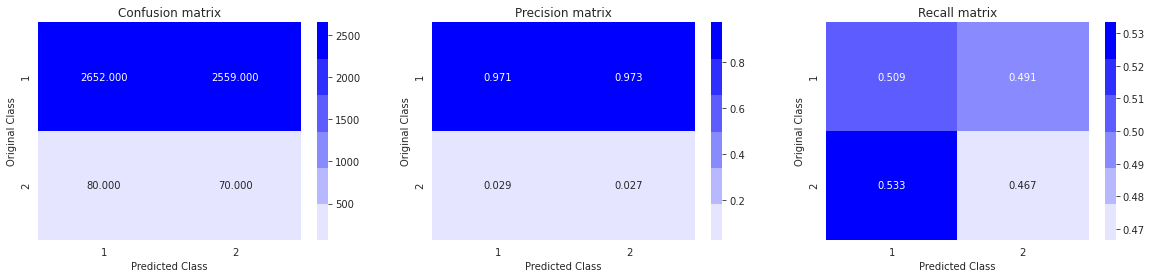

In [107]:
pred_y = [np.random.randint(2) for i in range(len(X_test))]

test_f1 = f1_score(y_test, pred_y,average='micro')
final_score['Random'] = test_f1
print("Test f1-Score: ", test_f1)
plot_confusion_matrix(y_test, pred_y)

it shows some random results, so that we can use this f1 score as minimum or base score 

##Logistic Regression:

best alpha =  1e-05 Test-f1-score =  0.9781757134862898


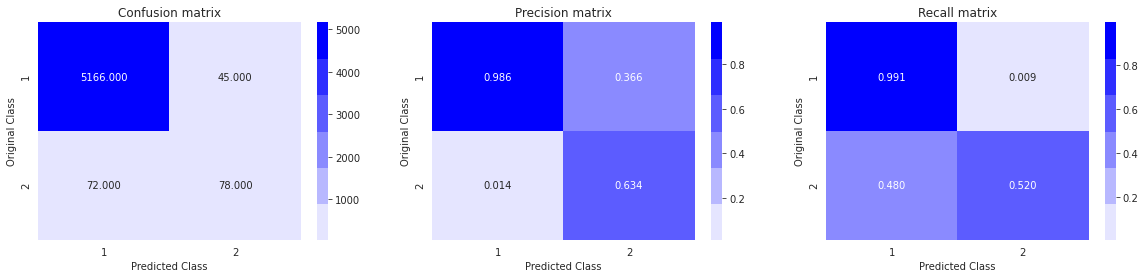

In [108]:
# Hyperparameter tuning

alpha = [10 ** x for x in range(-5, 2)]
score = []
for i in alpha:
  model = SGDClassifier(loss='log', alpha=i, penalty='l2')
  model.fit(X_train, y_train)
  pred_y = model.predict(X_cv)
  score.append((f1_score(y_cv, pred_y,average='micro')))

#Training the model with the best hyperparameter 
best_alpha = alpha[np.argmax(score)]
model = SGDClassifier(loss='log', alpha=alpha[np.argmax(score)], penalty='l2')
model.fit(X_train, y_train)
pred_y = model.predict(X_test)

test_f1 = f1_score(y_test, pred_y,average='micro')
final_score['Logistic-Regression'] = test_f1
print("best alpha = ",best_alpha,"Test-f1-score = ", test_f1)
plot_confusion_matrix(y_test, pred_y)

Recall value for positve label is very less

#KNN:

best K =  9 Test-f1-score =  0.9759373251259094


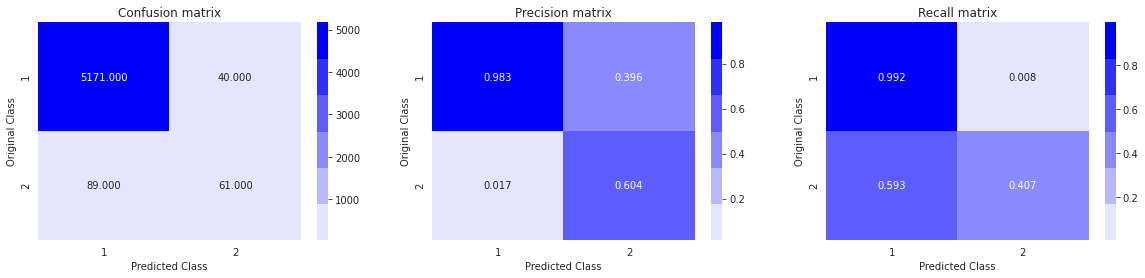

In [109]:
# Hyperparameter tuning

K = np.arange(1, 100, 4).tolist()
score = []
for k in K:
  model = KNeighborsClassifier(n_neighbors=k)
  model.fit(X_train, y_train)
  pred_y = model.predict(X_cv)
  score.append((f1_score(y_cv, pred_y,average='micro')))

#Training the model with the best hyperparameter
best_k = K[np.argmax(score)]
model = KNeighborsClassifier(n_neighbors=k)
model.fit(X_train, y_train)
pred_y = model.predict(X_test)

test_f1 = f1_score(y_test, pred_y,average='micro')
final_score['KNN'] = test_f1
print("best K = ",best_k,"Test-f1-score = ", test_f1)
plot_confusion_matrix(y_test, pred_y)

with the best hyperparameter results of KNN are pretty similar with Logisitc Regression 

##SVM (Linear):

best alpha =  10 Test-f1-score =  0.9791083753031152


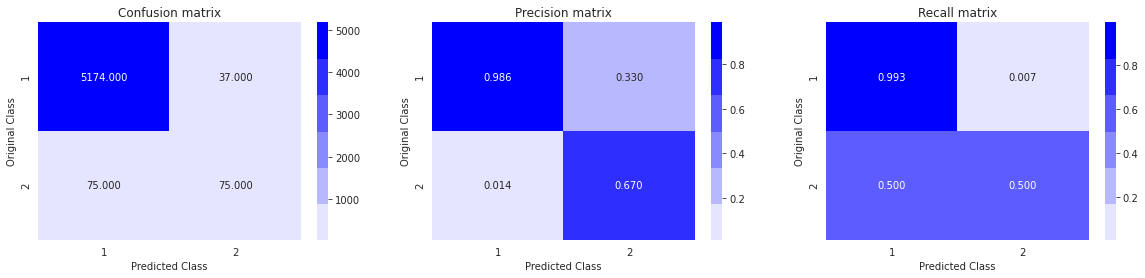

In [110]:
# Hyperparameter tuning

alpha = [10 ** x for x in range(-5, 2)]
score = []
for i in alpha:

  model = SVC(C=i, kernel='linear')
  model.fit(X_train, y_train)
  pred_y = model.predict(X_cv)
  score.append((f1_score(y_cv, pred_y,average='micro')))

#Training the model with the best hyperparameter
best_alpha = alpha[np.argmax(score)]
model = SVC(C=best_alpha, kernel='linear')
model.fit(X_train, y_train)
pred_y = model.predict(X_test)

test_f1 = f1_score(y_test, pred_y,average='micro')
final_score['Linear-SVM'] = test_f1
print("best alpha = ",best_alpha,"Test-f1-score = ", test_f1)
plot_confusion_matrix(y_test, pred_y)

Precision and Recall values are improved but overall f1-score is almost as same as with the logisitc regression's f1-score

##SVM (RBF):

best alpha =  10 Test-f1-score =  0.9807871665734005


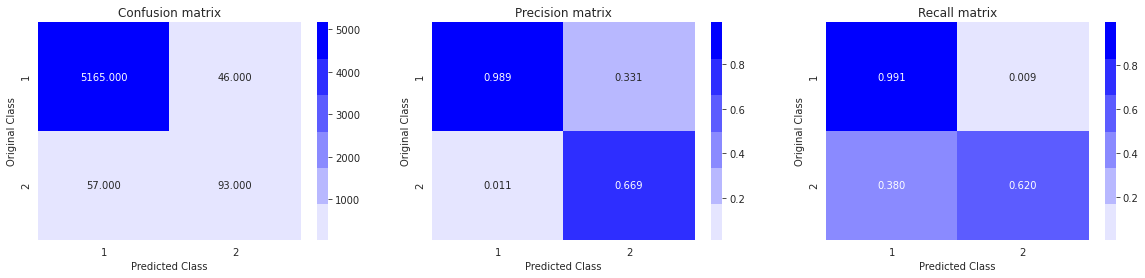

In [111]:
# Hyperparameter tuning

alpha = [10 ** x for x in range(-5, 2)]
score = []
for i in alpha:

  model = SVC(C=i)
  model.fit(X_train, y_train)
  pred_y = model.predict(X_cv)
  score.append((f1_score(y_cv, pred_y,average='micro')))

#Training the model with the best hyperparameter
best_alpha = alpha[np.argmax(score)]
model = SVC(C=best_alpha)
model.fit(X_train, y_train)
pred_y = model.predict(X_test)

test_f1 = f1_score(y_test, pred_y,average='micro')
final_score['RBF-SVM'] = test_f1
print("best alpha = ",best_alpha,"Test-f1-score = ", test_f1)
plot_confusion_matrix(y_test, pred_y)

this svm with rbf has achieved good amount of precision for both but still lacking with recall for positive label

#Decision Tree:

best Depth =  10 Test-f1-score =  0.978735310576385


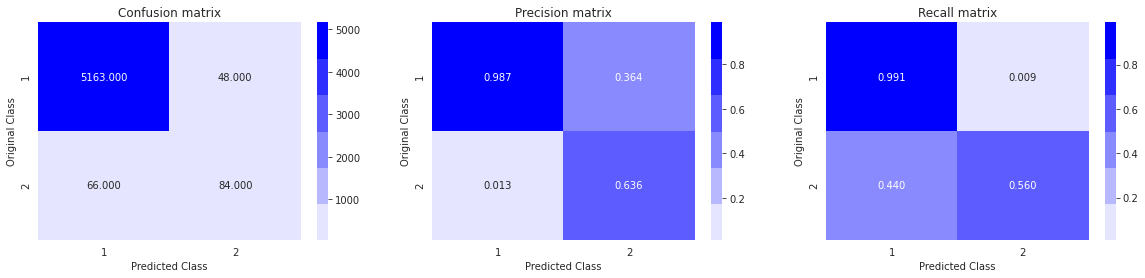

In [112]:
# Hyperparameter tuning

Depth = [5, 10, 50, 100, 200, 500]
score = []
for d in Depth:

  model = DecisionTreeClassifier(max_depth=d)
  model.fit(X_train, y_train)
  pred_y = model.predict(X_cv)
  score.append((f1_score(y_cv, pred_y,average='micro')))

#Training the model with the best hyperparameter
best_d = Depth[np.argmax(score)]
model = DecisionTreeClassifier(max_depth=best_d)
model.fit(X_train, y_train)
pred_y = model.predict(X_test)

test_f1 = f1_score(y_test, pred_y,average='micro')
final_score['Decision-Tree'] = test_f1
print("best Depth = ",best_d,"Test-f1-score = ", test_f1)
plot_confusion_matrix(y_test, pred_y)

##Random Forest:

best Depth =  500 Test-f1-score =  0.9824659578436858


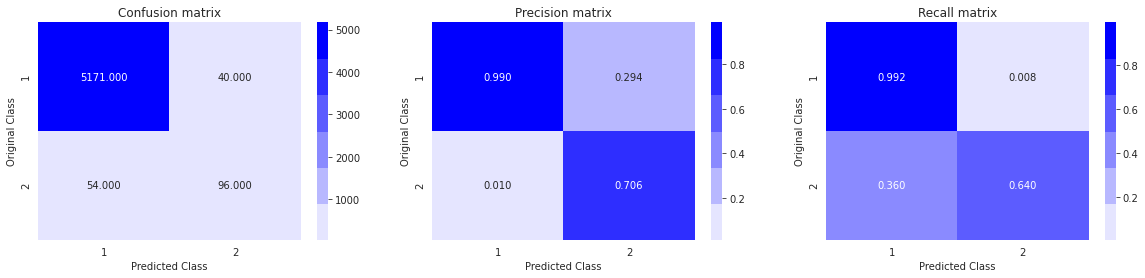

In [113]:
# Hyperparameter tuning

estimators = [5, 10, 50, 100, 200, 500]
score = []
for e in estimators:

  model = RandomForestClassifier(n_estimators=e, max_depth=100)
  model.fit(X_train, y_train)
  pred_y = model.predict(X_cv)
  score.append((f1_score(y_cv, pred_y,average='micro')))

#Training the model with the best hyperparameter
best_e = estimators[np.argmax(score)]
model = RandomForestClassifier(n_estimators=best_e, max_depth=100)
model.fit(X_train, y_train)
pred_y = model.predict(X_test)

test_f1 = f1_score(y_test, pred_y,average='micro')
final_score['Random-Forest'] = test_f1
print("best Depth = ",best_e,"Test-f1-score = ", test_f1)
plot_confusion_matrix(y_test, pred_y)

it is pretty good as compare to Decision Tree in terms of false postives

#Gradient-Boosting:

best Depth =  500 Test-f1-score =  0.983025554933781


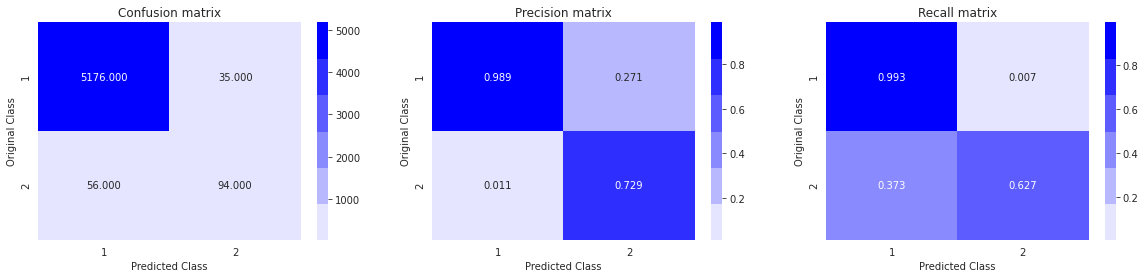

In [114]:
# Hyperparameter tuning

estimators = [5, 10, 50, 100, 200, 500]
score = []
for e in estimators:

  model = XGBClassifier(n_estimators=e)
  model.fit(X_train, y_train)
  pred_y = model.predict(X_cv)
  score.append((f1_score(y_cv, pred_y,average='micro')))

#Training the model with the best hyperparameter
best_e = estimators[np.argmax(score)]
model = XGBClassifier(n_estimators=best_e)
model.fit(X_train, y_train)
pred_y = model.predict(X_test)

test_f1 = f1_score(y_test, pred_y,average='micro')
final_score['Gradient-Boosting'] = test_f1
print("best Depth = ",best_e,"Test-f1-score = ", test_f1)
plot_confusion_matrix(y_test, pred_y)

This model has shown the highest Recall value as compare to all previous models

In [118]:
#Results

final_score = dict(sorted(dict(final_score).items(), key = lambda kv:(kv[1], kv[0])))
from prettytable import PrettyTable
    
x = PrettyTable()
x.field_names = ["No", "Model", "micro F1-Score"]
model = XGBClassifier(n_estimators=best_e)
model.fit(X_train, y_train)
pred_y = model.predict(X_test)

test_f1 = f1_score(y_test, pred_y,average='micro')
for idx, (model, f1) in enumerate(final_score.items()):
  x.add_row([idx+1, model, f1])
print(x)

+----+---------------------+--------------------+
| No |        Model        |   micro F1-Score   |
+----+---------------------+--------------------+
| 1  |        Random       | 0.5077410930796493 |
| 2  |         KNN         | 0.9759373251259094 |
| 3  | Logistic-Regression | 0.9781757134862898 |
| 4  |    Decision-Tree    | 0.978735310576385  |
| 5  |      Linear-SVM     | 0.9791083753031152 |
| 6  |       RBF-SVM       | 0.9807871665734005 |
| 7  |    Random-Forest    | 0.9824659578436858 |
| 8  |  Gradient-Boosting  | 0.983025554933781  |
+----+---------------------+--------------------+


In [121]:
# Saving the Best model  
import pickle

pkl_filename = "/content/drive/My Drive/Case-Study 2 /Model/model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

##Conclusion:-

  So, after complition of the various Machine Learning model's training. we can conlude that the Gradient-Boosting is best model among the other models which has achieved micro F1-Score = 0.9830 on Test Data after Tuning with the "n_estimator" hyperparameter on cross-validation set 
  Next, we will train the same models on the top features which we have calculated with histigram's bin column too..